In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
import pandas as pd
import xml.etree.ElementTree as et
import datetime
from skimage.io import imread, imsave
from imageio import volread as imread
import tifffile
import pystackreg
from pystackreg import StackReg
from skimage.filters import threshold_otsu
from pystackreg.util import to_uint16   # make sure version 0.2.5 (not anything below)
# from ims_to_tiff import convert_to_tif  
from tqdm.notebook import tqdm
import seaborn as sns
import pylab as pl

In [ ]:
# copy data over 
!gsutil -m cp -rv gs://fc-secure-9289bfef-e5cb-493a-83d5-e604cd429e39/Brian/090223_D37_MSN_CellPaint_2/Plate1_Well2 .

### Converting to TIF

In [ ]:
# There is a much better way to do this on the command line -- there should be a separate documentation
# If you want to run in jupyter notebook, continue

In [1]:
IMG_DIR = "IMS_IMAGES_DIRECTORY_PATH"

In [6]:
# Change "reg_ex" with a regular expression for all files in the directory
# for example, if all of the files have the word "Plate" in it, the reg_ex should be replaced with Plate
cycles = glob.glob(f'{IMG_DIR}/*reg_ex*')     

In [5]:
cycles

['041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0120.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0093.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0159.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0149.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0137.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0155.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0146.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0138.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0157.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0145.tif',
 '041924_HD_CellPaint_Stressors_msGlia_D28_Processed/images_2_channel/Plate_3_F0161.tif',
 '041924_H

In [4]:
error_files = []
for i in cycles:
    ims = glob.glob(f'{i}/*')
    for file in ims:
        try:
            sourceFile = file
            destFile = "tif/" + file[:-4]+'.tif'
            #print(destFile)
            convert_to_tif(sourceFile, destFile)
        except:
            print(f'{i} has B-tree error or import error')
            error_files.append(file)
            pass
# you can check for any error files by printing out the error_files list

ATF6_CHOP_Field_B2 has B-tree error or import error
ATF6_CHOP_Field_B2 has B-tree error or import error
File Breakdown
______________
Channels: 4
Time Points: 1
Z Levels: 2
Native (rows, cols): (2048,2048)
______________
TimePoint 0/0
TimePoint 0/0 Z 1/1
File Breakdown
______________
Channels: 4
Time Points: 1
Z Levels: 2
Native (rows, cols): (2048,2048)
______________
TimePoint 0/0
TimePoint 0/0 Z 1/1
File Breakdown
______________
Channels: 4
Time Points: 1
Z Levels: 2
Native (rows, cols): (2048,2048)
______________
TimePoint 0/0
TimePoint 0/0 Z 1/1
File Breakdown
______________
Channels: 4
Time Points: 1
Z Levels: 2
Native (rows, cols): (2048,2048)
______________
TimePoint 0/0
TimePoint 0/0 Z 1/1
File Breakdown
______________
Channels: 4
Time Points: 1
Z Levels: 2
Native (rows, cols): (2048,2048)
______________
TimePoint 0/0
TimePoint 0/0 Z 1/1
File Breakdown
______________
Channels: 4
Time Points: 1
Z Levels: 2
Native (rows, cols): (2048,2048)
______________
TimePoint 0/0
TimePoint 

### Registration (Testing)

In [2]:
sample = "NAME_OF_SAMPLE"   # for example "061224_CellPainting_CorticalNeurons"
TIF_DIR = "tif"
REF_CYCLE_DIR = "Cycle_Field_1"
MOV_CYCLE_DIR = "Cycle_1_Field_1"

In [4]:
ref = imread(f'{TIF_DIR}/{REF_CYCLE_DIR}/Cycle_F000.tif') # change reference.tif with real name of image
mov = imread(f'{TIF_DIR}/{MOV_CYCLE_DIR}/Cycle_1_F000.tif') # change moved.tif with real name of image
 
ref_max = ref.max(0)   # max proj of z for each channel in reference
ref_binary = ref_max[0] > threshold_otsu(ref_max[0])  # binarizing 0th channel - change for DNA channel 

mov_max = mov.max(0)  # max projection by each cycle in for loop (ref above)
mov_binary = mov_max[0] > threshold_otsu(mov_max[0]) # binary of moved image
    
sr = StackReg(StackReg.RIGID_BODY)
tmat = sr.register(ref_binary, mov_binary)   # creating transformation matrix 
out_binary = sr.transform(mov_binary) 

In [5]:
tmat

array([[ 1.00000000e+00, -1.33315004e-05, -1.59389152e-01],
       [ 1.33315004e-05,  1.00000000e+00,  2.53187086e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


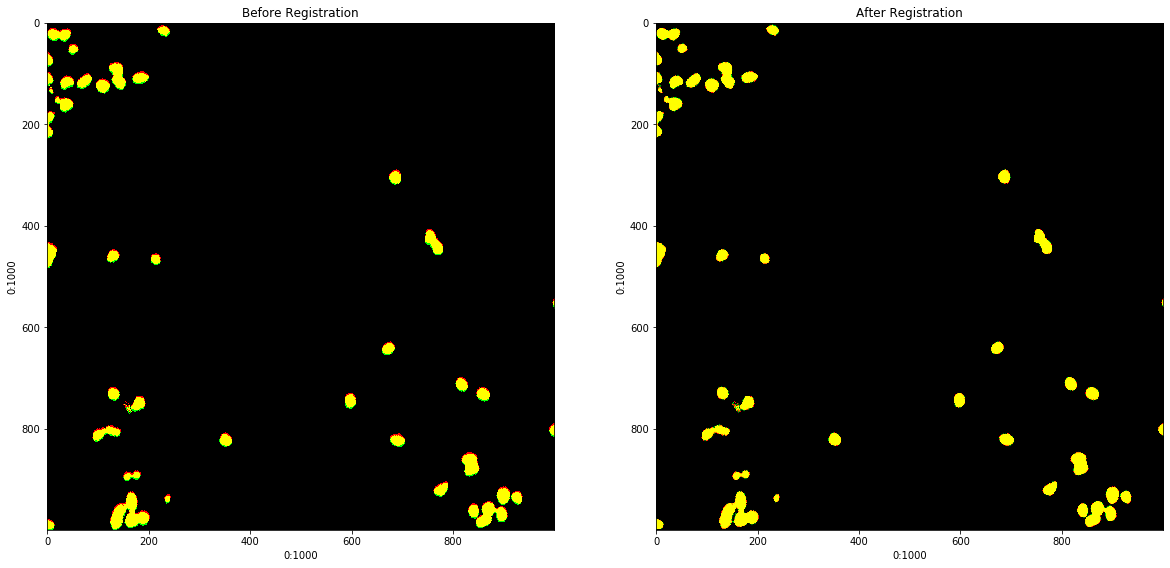

In [6]:
fig, axs = plt.subplots(1,2,figsize = (20,60))
axs = axs.ravel()

im_reg = np.zeros((2048, 2048,3)) # empty color image
im_reg[...,0] = ref_binary
im_reg[...,1] = out_binary
    
im_orig = np.zeros((2048, 2048,3))
im_orig[...,0] = ref_binary
im_orig[...,1] = mov_binary
    
axs[0].imshow(im_orig[0:1000, 0:1000])   #before reg
    
axs[1].imshow(im_reg[0:1000, 0:1000])   #after reg


axs[0].title.set_text('Before Registration')
axs[1].title.set_text('After Registration')

for ax in axs.flat:
    ax.set(xlabel='0:1000', ylabel='0:1000')

In [7]:
reg = np.zeros(mov.shape, dtype=np.uint16) # initialize with the right dtype
for Z in range(mov.shape[0]): # Z 
    print(f"Z-plane: {Z} registering")
    for ch in range(mov.shape[1]): # channels
        reg[Z,ch,...] = sr.transform(mov[Z,ch,...], tmat=tmat)
        reg[Z,ch,...] = to_uint16(reg[Z,ch,...])

Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering


In [8]:
# setting a small window of the image to check by eye -- you can change the numbers as you wish
reg_max = reg.max(0)
reg_v = reg_max[0, ...]
reg_v = reg_v[100:200, 100:200]
reg_v.shape

(100, 100)

[[115 112 110 ... 322 296 267]
 [113 112 116 ... 347 327 332]
 [111 113 118 ... 372 389 329]
 ...
 [109 105 106 ... 107 109 106]
 [106 108 107 ... 107 111 104]
 [108 111 104 ... 111 107 106]]  
 
 [[114 119 119 ... 408 383 334]
 [114 116 127 ... 496 424 364]
 [114 124 126 ... 546 504 410]
 ...
 [108 109 102 ... 104 105 110]
 [108 107 105 ... 103 106 108]
 [109 105 106 ... 105 105 108]]


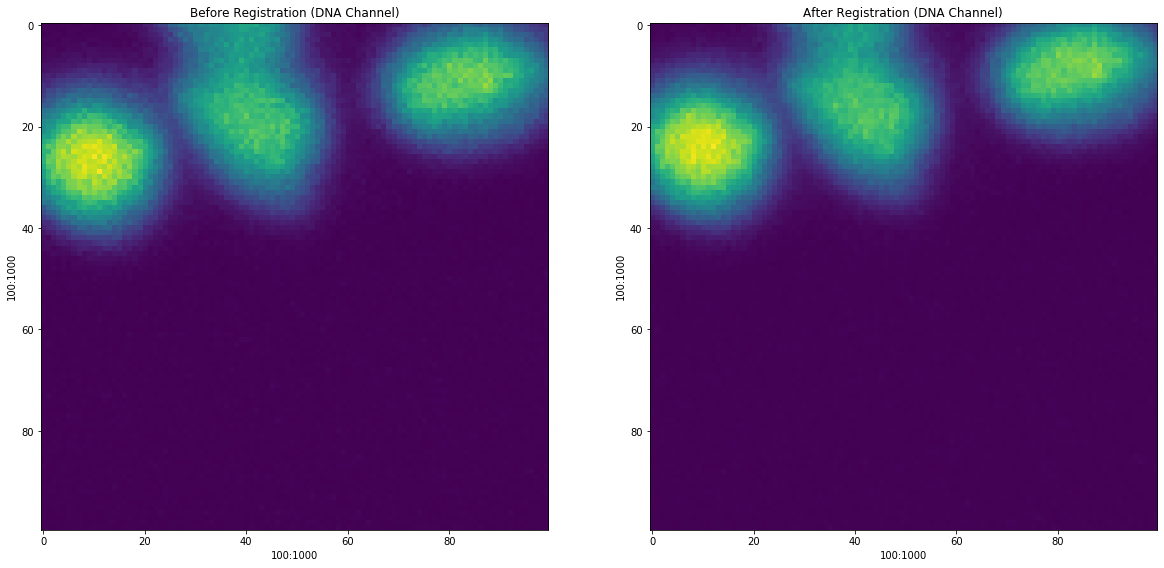

In [11]:
# COMPARING BETWEEN ORIGNIAL IMAGE AND REGISTERED IMAGE -- looking by eye to check that the image has moved

orig = imread(f'{TIF_DIR}/{MOV_CYCLE_DIR}/Cycle_1_F000.tif')
orig = orig.max(0)
orig = orig[0, ...]
orig_v = orig[100:200, 100:200]

f, ax = plt.subplots(1,2, figsize = (20,60))
ax[0].imshow(orig_v)
ax[1].imshow(reg_v)
ax[0].title.set_text('Before Registration (DNA Channel)')
ax[1].title.set_text('After Registration (DNA Channel)')

for ax in ax.flat:
    ax.set(xlabel='100:1000', ylabel='100:1000')

print(orig_v," \n" , "\n",reg_v)

### Registration

In [ ]:
sample = "NAME_OF_SAMPLE"   # this was defined at the testing stage above\
output = "output"

In [12]:
# Set up number of channels and number of FOVs
CYCLE_NUMS = 3
NUM_FOVS = 25

In [19]:
for i in range(CYCLE_NUMS):
    if i == 0:
        continue
    os.makedirs(f'tmat_Cyc_{i}')
    os.makedirs(f'reg_bin_Cyc_{i}')
    os.makedirs(f'reg_Cyc_{i}') 
    os.makedirs(f'tif/Cycle_{i}') 
os.makedirs(f'tif/Cycle_0')
os.makedirs('output')

In [27]:
for i in range(CYCLE_NUMS):
    if i == 0:
        os.system('mv tif/Cycle_F*/* tif/Cycle_0')
    os.system(f'mv tif/Cycle_*{i}*Field*/* tif/Cycle_{i}')

os.system(f'rm -rf tif/Cycle_*Field*')

0

In [28]:
### CHECK IF REFERENCE FOV IS BEING MATCHED TO SAME MOVED FOV, ACROSS ALL CYCLES AND FOVS IN EVERY ITERATION

for c in range(CYCLE_NUMS-1):   
    refs = iter(sorted(glob.glob(f'tif/Cycle_0/*'))) # list of cycle 0 .tif 
    movs = iter(sorted(glob.glob(f'tif/Cycle_{c+1}/*'))) # cycle 1, 2, 3, .tif list --> FOV000, 001, (002 = error) 005 006 
    for FOV in range(0, NUM_FOVS): 
        #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
        ref_name = next(refs) 
        mov_name = next(movs)

        ref_num = ref_name.split('_F')[1][0:3]
        mov_num = mov_name.split('_F')[1][0:3]
        if ref_num != mov_num:
            print("False")

In [29]:
# define jaccard
def jaccard(img1, img2):
    assert img1.dtype == 'bool', 'input must be boolean'
    assert img2.dtype == 'bool', 'input must be boolean'
    AND = np.sum(img1&img2)
    OR = np.sum(img1|img2)
    J = AND/OR
    return J
reg_J = pd.DataFrame()     # dataframe of jaccard index of cells after registration
base_J = pd.DataFrame()     # dataframe of jaccard index of cells before registration

In [31]:
for c in range(CYCLE_NUMS-1):    
    refs = iter(sorted(glob.glob(f'tif/Cycle_0/*'))) # list of cycle 0 .tif 
    movs = iter(sorted(glob.glob(f'tif/Cycle_{c+1}/*'))) # cycle 1, 2, 3, .tif list --> FOV000, 001, (002 = error) 005 006 
    for FOV in range(0, NUM_FOVS): 
        #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
        ref_name = next(refs) 
        ref = imread(ref_name)
        ref = ref.astype(np.uint16)
        mov_name = next(movs)
        mov = imread(mov_name)
        mov = mov.astype(np.uint16)
        FOV_num = mov_name.split('_F')[1][0:3]
        print(f'cycle {c+1} field {FOV_num} ')

        ref_max = ref.max(0)
        ref_binary = ref_max[0] > threshold_otsu(ref_max[0]) # nuclei channel
        mov_max = mov.max(0)
        mov_binary = mov_max[0] > threshold_otsu(mov_max[0]) # nuclei channel
        print("Got threshold")
        sr = StackReg(StackReg.RIGID_BODY)  
        tmat = sr.register(ref_binary, mov_binary) 
        out = sr.transform(mov_binary) 
        out = pystackreg.util.to_uint16(out) 
        
        base_J.loc[FOV_num, str(c+1)] = jaccard(ref_binary, mov_binary)
        reg_J.loc[FOV_num, str(c+1)] = jaccard(ref_binary, out.astype('bool'))

        # save binary
        fname_to_save = f'reg_bin_Cyc_{c+1}' + f'/Cycle_{c+1}_F{FOV_num}_bin_reg.tif'
        print('Saving Binary Registered Images...', fname_to_save)
        tifffile.imwrite(fname_to_save, out, imagej=True, photometric = 'minisblack',metadata={'axes':'YX'})

        # save tmat
        print("saving tmat")
        np.save(f'tmat_Cyc_{c+1}' + f'/Cycle_{c+1}_F{FOV_num}_tmat.npy', tmat)
        
        # THE REGISTRATION STEP
        reg = np.zeros(mov.shape, dtype=np.uint16)               # initialize with the right dtype
        for Z in range(mov.shape[0]):
            print(f"Z-plane: {Z} registering")
            for ch in range(mov.shape[1]): 
                reg[Z,ch,...] = sr.transform(mov[Z,ch,...], tmat=tmat)
                reg[Z,ch,...] = to_uint16(reg[Z,ch,...])

        fname_to_save = f'reg_Cyc_{c+1}' + f'/Cycle_{c+1}_F{FOV_num}_reg.tif'
        print('Saving Registered Images...', fname_to_save)
        tifffile.imwrite(fname_to_save, reg, imagej=True,
                         photometric = 'minisblack',metadata={'axes':'ZCYX'})
base_J.to_csv('output/base_J.csv')
reg_J.to_csv('output/reg_J.csv')

cycle 1 field 000 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_1/Cycle_1_F000_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering
Saving Registered Images... reg_Cyc_1/Cycle_1_F000_reg.tif
cycle 1 field 001 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_1/Cycle_1_F001_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering
Saving Registered Images... reg_Cyc_1/Cycle_1_F001_reg.tif
cycle 1 field 002 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_1/Cycle_1_F002_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 register

Saving Binary Registered Images... reg_bin_Cyc_1/Cycle_1_F020_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering
Saving Registered Images... reg_Cyc_1/Cycle_1_F020_reg.tif
cycle 1 field 021 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_1/Cycle_1_F021_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering
Saving Registered Images... reg_Cyc_1/Cycle_1_F021_reg.tif
cycle 1 field 022 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_1/Cycle_1_F022_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plan

Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering
Saving Registered Images... reg_Cyc_2/Cycle_2_F015_reg.tif
cycle 2 field 016 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_2/Cycle_2_F016_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering
Z-plane: 9 registering
Saving Registered Images... reg_Cyc_2/Cycle_2_F016_reg.tif
cycle 2 field 017 
Got threshold
Saving Binary Registered Images... reg_bin_Cyc_2/Cycle_2_F017_bin_reg.tif
saving tmat
Z-plane: 0 registering
Z-plane: 1 registering
Z-plane: 2 registering
Z-plane: 3 registering
Z-plane: 4 registering
Z-plane: 5 registering
Z-plane: 6 registering
Z-plane: 7 registering
Z-plane: 8 registering


NameError: name 'outputs' is not defined

### Looking at Max and Min Shifts

In [32]:
for idx, c in enumerate(range(CYCLE_NUMS-1)):     
    tmats = iter(glob.glob(f'tmat_Cyc_{c+1}/*'))
    for sFOV in range(0,NUM_FOVS): 
        tmat_name = next(tmats)
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]
        if (moveX > 15) | (moveY > 15)|(moveX < -15) | (moveY < -15): # 15 pixels is max
            print(c+1, tmat_name, moveX, moveY)

### QC

In [39]:
base_J.to_csv('output/base_J.csv')
reg_J.to_csv('output/reg_J.csv')

In [42]:
base_J

,1,2
0,0.803003,0.714084
1,0.695302,0.603306
2,0.799464,0.821109
3,0.706110,0.631974
4,0.801818,0.799654
5,0.812214,0.815307
6,0.796296,0.711591
7,0.815202,0.720920
8,0.793692,0.694857
9,0.806547,0.696848


([array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
  array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 2., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
  array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0.

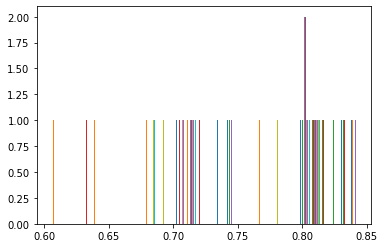

In [44]:
base_J = pd.read_csv('output/base_J.csv')
base_J = base_J.drop(["Unnamed: 0"], axis=1)
plt.hist(base_J)

([array([0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]),
  array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 2., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
  array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
  array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 0.

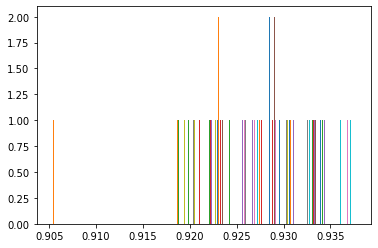

In [45]:
reg_J = pd.read_csv("output/reg_J.csv")
reg_J = reg_J.drop(["Unnamed: 0"], axis=1)
plt.hist(reg_J)

In [ ]:
# Making the table for the X and Y shift heatmap   ------ THIS TAKES A VERY SHORT AMOUNT OF TIME

for idx, c in enumerate(range(CYCLE_NUMS-1)):
    fig, axes = plt.subplots()
    tmats = iter(glob.glob(f'tmat_Cyc_{c+1}/*'))
    dfX = pd.DataFrame(0, index=['0','1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'], 
                   columns=['0','1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
    dfY = pd.DataFrame(0, index=['0','1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'], 
                   columns=['0','1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])
    for sFOV in range(0,NUM_FOVS):
        tmat_name = next(tmats)
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]
        
        col = str(int(tmat_name.split('_')[6]))
        row = str(int(tmat_name.split('_')[7][0:3]))

        dfX.loc[row, col] = moveX
        dfY.loc[row, col] = moveY
        
    sns.heatmap(dfX, vmin=-20, vmax=20)
    pl.suptitle(f"Cycle {c+1} X-shift")
    
#     fig, axes = plt.subplots()
#     sns.heatmap(dfY, vmin=-100, vmax=100)
#     pl.suptitle(f"Cycle {c+1} Y-shift")

In [48]:
# Be sure to remove problematic FOVs and then updating NUM_FOVS with the new number of FOVs
dfX_shift = pd.DataFrame()
dfY_shift = pd.DataFrame()
for idx, c in enumerate(range(CYCLE_NUMS-1)):
    tmats = iter(sorted(glob.glob(f'tmat_Cyc_{c+1}/*')))
    for sFOV in range(0,NUM_FOVS):
        tmat_name = next(tmats)
        FOV_num = tmat_name.split('_F')[1][0:3]
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]

        dfX_shift.loc[FOV_num, str(c+1)] = moveX
        dfY_shift.loc[FOV_num, str(c+1)] = moveY
dfX_shift.to_csv('output/X_shift.csv')
dfY_shift.to_csv('output/Y_shift.csv')

([array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
  array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
  array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
  array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 1.

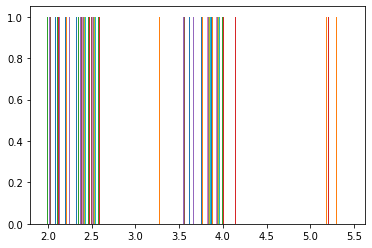

In [50]:
dfY_shift = pd.read_csv("output/Y_shift.csv")
dfY_shift = dfY_shift.drop(["Unnamed: 0"], axis=1)
plt.hist(dfY_shift)


([array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
  array([0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 1., 0.

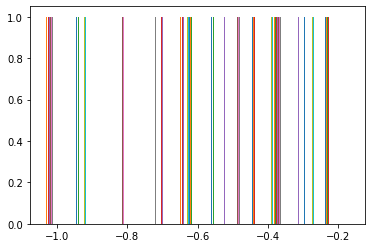

In [51]:
dfX_shift = pd.read_csv("output/X_shift.csv")
dfX_shift = dfX_shift.drop(["Unnamed: 0"], axis=1)
plt.hist(dfX_shift)


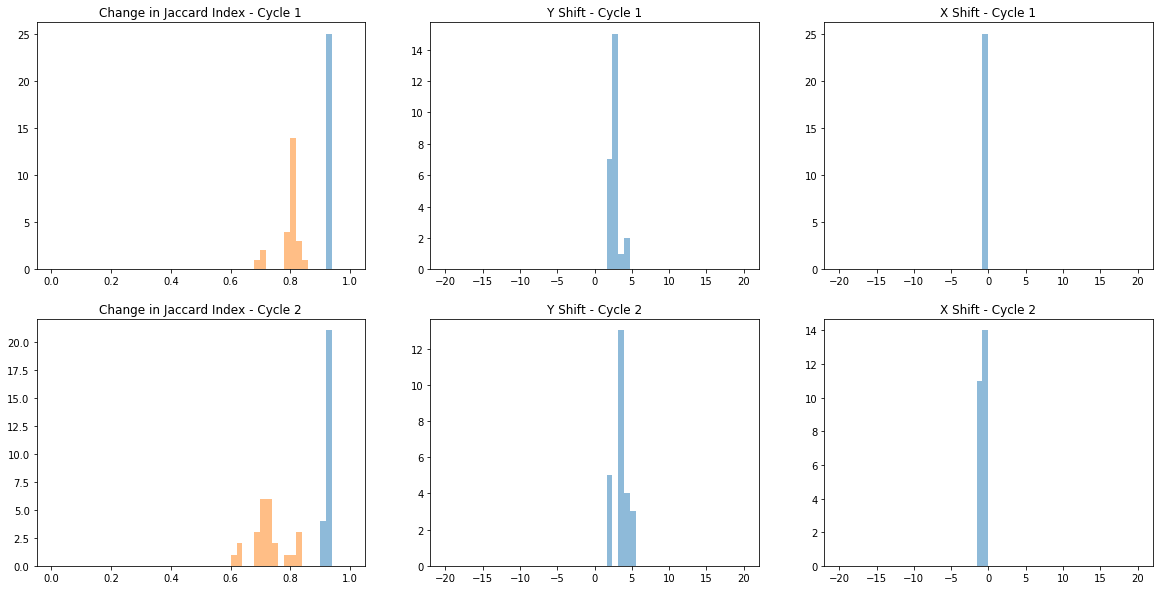

In [55]:
fig, axs = plt.subplots(CYCLE_NUMS-1, 3, figsize=(20,10))

for cycle in range(CYCLE_NUMS-1):
    axs[cycle][0].hist(reg_J[f'{cycle+1}'], bins = 50, alpha=0.5, label='reg_J', range=[0,1])
    axs[cycle][0].hist(base_J[f'{cycle+1}'], bins = 50, alpha=0.5, label='base_J', range=[0,1])
    
    axs[cycle][1].hist(dfY_shift[f'{cycle+1}'], bins = 50, alpha=0.5, label='dfX_shift', range=[-20,20])
    axs[cycle][2].hist(dfX_shift[f'{cycle+1}'], bins = 50, alpha=0.5, label='dfX_shift', range=[-20,20])
    
    axs[cycle][0].title.set_text(f'Change in Jaccard Index - Cycle {cycle+1}')
    axs[cycle][1].title.set_text(f'Y Shift - Cycle {cycle+1}')
    axs[cycle][2].title.set_text(f'X Shift - Cycle {cycle+1}')

#     for ax in axs.flat:
#         ax.set(xlabel='', ylabel='')

In [60]:
# We are trying to look for registered binaries that have intensity percentage less than 0.1 percent (< 0.001)
# you can change the percentage depending on the data -- can differ for varying cell density
hist = pd.DataFrame()
err_lst = []
err_lst2 = []

for c in range(CYCLE_NUMS-1):    
    binas = iter(glob.glob(f'reg_bin_Cyc_{c+1}/*')) 
    for FOV in range(0, NUM_FOVS): # 
        #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
        bina_name = next(binas)
        print(bina_name)
        bina = imread(bina_name)
        bina = bina.astype(np.uint16)
        FOV_num = bina_name[-15:-12]
        
        percentage = (np.sum(bina))/(2048*2048)    
        
        if percentage < 0.001:  ### can change percentage here -- replace 0.001 with another number
            err_lst.append(bina_name)
        if percentage < 0.01:  ### can change percentage here -- replace 0.01 with another number
            err_lst2.append(bina_name)
            
        hist.loc[FOV_num, f'{c+1}'] = percentage    # this is the table of percent of signal in images

reg_bin_Cyc_1/Cycle_1_F000_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F001_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F002_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F003_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F004_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F005_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F006_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F007_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F008_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F009_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F010_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F011_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F012_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F013_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F014_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F015_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F016_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F017_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F018_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F019_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F020_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F021_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F022_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F023_bin_reg.tif
reg_bin_Cyc_1/Cycle_1_F024_bin_reg.tif
reg_bin_Cyc_2/Cycle_2_F00

In [58]:
err_lst

[]

In [59]:
err_lst2

[]

In [ ]:
import pylab as pl
for c in range(CYCLE_NUMS-1):
    hist.hist(column=f'{c+1}', bins = 80, range=[0, 0.2])
    pl.suptitle(f"Cycle {c+1}")

### Merging and Cropping

In [61]:
# Make sure NUM_FOVS is correctly defined
NUM_FOVS

25

In [62]:
## print('X shift and Y shift max min values')
x_max_list=[]
x_min_list=[]
y_max_list=[]
y_min_list=[]
X_indices =[]
Y_indices =[]
X_SHIFT_df = pd.DataFrame
Y_SHIFT_df = pd.DataFrame

for c in range(CYCLE_NUMS-1):     
    tmats = iter(glob.glob(f'tmat_Cyc_{c+1}/*'))
    X_SHIFT = []
    Y_SHIFT = []
    X_RIG = []
    Y_RIG = []
    for sFOV in range(0,NUM_FOVS): 
        tmat_name = next(tmats)
        fov = tmat_name.split('_F')[1][0:3]
        tmat_loaded = np.load(tmat_name)
        moveX = tmat_loaded[0,2]
        moveY = tmat_loaded[1,2]
        if moveX > 0:
            moveX = moveX + 2048*np.tan(np.arcsin(tmat_loaded[0,1]))
            X_RIG = []
        if moveY < 0:
            moveY = moveY - 2048*np.tan(np.arcsin(tmat_loaded[0,1]))
        X_SHIFT.append(moveX)
        Y_SHIFT.append(moveY)
        
#         X_SHIFT_df.loc[fov, c] = moveX
#         Y_SHIFT_df.loc[fov, c] = moveY

    X_max = max(X_SHIFT)
    X_min = min(X_SHIFT)
    Y_max = max(Y_SHIFT)
    Y_min = min(Y_SHIFT)

    print('\n', f'tmat_Cyc_{c+1} \n', X_max,X_min,Y_max,Y_min)

    def round_shift(val):
        import math
        if val <0: # if negative,
            val = math.floor(val)
        else:
            val = math.ceil(val)
        return val

    X_max = round_shift(X_max)
    X_min = round_shift(X_min)
    Y_max = round_shift(Y_max)
    Y_min = round_shift(Y_min)
    
    x_max_list.append(X_max)
    x_min_list.append(X_min)
    y_max_list.append(Y_max)
    y_min_list.append(Y_min)
    print(f'X_max:{X_max}',f'X_min:{X_min}',f'Y_max:{Y_max}',f'Y_min:{Y_min}')

X_max_total = max(x_max_list)
X_min_total = min(x_min_list)
Y_max_total = max(y_max_list)
Y_min_total = min(y_min_list)

print('\n', f'X_max_total:{X_max_total}', f'X_min_total:{X_min_total}', 
      f'Y_max_total:{Y_max_total}', f'Y_min_total:{Y_min_total}')

# X_SHIFT_df.to_csv('X_SHIFT_df.csv',sep=',')
# Y_SHIFT_df.to_csv('Y_SHIFT_df.csv',sep=',')


 tmat_Cyc_1 
 -0.15938915168101175 -0.5334699063978405 4.1193175765307615 1.9431267056837669
X_max:-1 X_min:-1 Y_max:5 Y_min:2

 tmat_Cyc_2 
 -0.5329277164026962 -1.0414144008259427 5.4848402989141505 1.9358985531365533
X_max:-1 X_min:-2 Y_max:6 Y_min:2

 X_max_total:-1 X_min_total:-2 Y_max_total:6 Y_min_total:2


In [64]:
im1 = imread('tif/Cycle_0/Cycle_F000.tif')
Y_total = len(im1[0][0][0])    # 2048
X_total = len(im1[0][0][1])    # 2048
print(Y_total, X_total)

2048 2048


In [65]:
# checking shape of image
im1 = imread('reg_Cyc_1/Cycle_1_F000_reg.tif')
im2 = im1[:,1,...]
im2.shape

(10, 2048, 2048)

In [66]:
###############################
X_abs_shift = [abs(X_max_total), abs(X_min_total)]
Y_abs_shift = [abs(Y_max_total), abs(Y_min_total)] 

def crop(X_x, X_n, Y_x, Y_n, img, pad):
    Y_total = img.shape[3]    # 2048
    X_total = img.shape[-1]     # 2048
    print('image shape', Y_total, X_total)
    
    if X_x * X_n > 0:   # same signs --> both negative or both positive
        Xlength = X_total - (max(X_abs_shift))
        print(Xlength)
        if X_x > 0: # moving left
            img = img[...,:, 0+pad:Xlength-pad]
        if X_x < 0:  # moving right 
            img = img[...,:, abs(X_n)+pad:X_total-pad]

    if X_x * X_n < 0:   # diff signs --> one is positive and other is negative
        Xlength = X_total  - (abs(X_x) + abs(X_n))
        print(Xlength)
        img = img[...,:, abs(X_n)+pad: X_total - abs(X_x)-pad] 
        
    if X_x == 0 and X_n < 0:
        Xlength = X_total  - abs(X_n)
        print(Xlength)
        img = img[...,:, abs(X_n)+pad:X_total-pad]
    if X_x == 0 and X_n == 0:
        Xlength = X_total
        print(Xlength)
        img = img[...,:, 0+pad:X_total-pad]
    if X_x > 0 and X_n == 0:
        Xlength = X_total - X_x
        print(Xlength)
        img = img[...,:, 0+pad:Xlength-pad]
### Y ## #
    if Y_x * Y_n > 0:   
        Ylength = Y_total - (max(Y_abs_shift))
        print(Ylength)
        if Y_x > 0: # up
            img = img[..., 0+pad:Ylength-pad, :]
        if Y_x < 0: # down
            img = img[...,abs(Y_n)+pad:Y_total-pad, :]
            
    if Y_x * Y_n < 0:  # Y_x > 0 , Y_n < 0
        Ylength = Y_total  - (abs(Y_x) + abs(Y_n)) # 
        print(Ylength)
        img = img[...,abs(Y_n)+pad:Y_total-abs(Y_x)-pad, :] 
        
    if Y_x == 0 and Y_n < 0: # down
        Ylength = Y_total  - abs(Y_n)
        print(Ylength)
        img = img[..., abs(Y_n)+pad:Y_total-pad, :]
        
    if Y_x == 0 and Y_n == 0:
        Ylength = Y_total
        print(Ylength)
        img = img[..., 0+pad:Y_total-pad,:]
        
    if Y_x > 0 and Y_n == 0:
        Ylength = Y_total - Y_x ## 
        print(Ylength)
        img = img[..., 0+pad:Ylength-pad, :] ## up  
    Xlength = Xlength - (pad*2)
    Ylength = Ylength - (pad*2)
    return Xlength, Ylength, img

In [74]:
IN_DIR = 'reg'
MERGE_DIR = 'merged' # output directory to save
Z = 10
final_ch = 10  # final channel number

pad = 10 # 10 pixel padding

!mkdir merged
!mkdir max 
!mkdir max_2_chan

In [77]:
refs = iter(glob.glob('tif/Cycle_0/*')) 
for FOV in range(NUM_FOVS):
    ref_name = next(refs)
    FOV_num = ref_name.split('_F')[1][0:3]
    print("FOV", FOV_num)
    #sFOV = str(FOV).zfill(NUM_DIGITS_OF_FOVS)
    img = imread(f'tif/Cycle_0/Cycle_F{FOV_num}.tif') # reference image that did not move
    img = img.astype(np.uint16)
    print("image max:",img.max())
    for cycle in range(CYCLE_NUMS-1):    
        fname = f'{IN_DIR}_Cyc_{cycle+1}/Cycle_{cycle+1}_F{FOV_num}_{IN_DIR}.tif'
        print('Appending... ', fname)
        im_to_add = imread(fname).astype(np.uint16)
        print(im_to_add.max())
        im_to_add[:,0,...] = img[:,0,...]
        img_last_3 = img[:,1:,...]
        img = np.append(im_to_add, img_last_3, axis=1) # concatenate along channel index
        print(f"Shape = {img.shape}") 
    fname = f'/F{FOV_num}.tif'
    print('saving', './{MERGE_DIR}'+fname)
    print('dtype of ', img.dtype)

    ########## CROP ################ --> CHANGE everytime depending on shifts
    Xlength, Ylength, img = crop(X_max_total, X_min_total, Y_max_total, Y_min_total, img, pad)

    assert img.shape[3] == Xlength, "Check X size"
    assert img.shape[2] == Ylength, "Check Y size"

    ### FINAL CHECK before saving ### 
    print("image Z:",img.shape[0])
    assert img.shape[0] == Z, "Check ZCYX"
    print("image final_ch:",img.shape[1])
    assert img.shape[1] == final_ch, "check final merge size"
    print("image max:", img.max())

    tifffile.imwrite(
        f'./{MERGE_DIR}'+fname,
        img,
        imagej=True,
        photometric='minisblack',
        metadata={'axes': 'ZCYX'},
    )

    del img # clear memory
    del im_to_add
    
for i in range(NUM_FOVS):
    try:
        sFOV = str(i).zfill(3)
        im = imread(f'merged/F{sFOV}.tif')
        max_im = im.max(0)
        tifffile.imwrite(f'max/F{sFOV}_max.tif', max_im, imagej=True, photometric = 'minisblack',metadata={'axes':'CYX'})
    except:
        continue

for i in range(NUM_FOVS):
    try:
        print(i)
        FOV = str(i).zfill(3)
        im_name = f'max/F{FOV}_max.tif'
        im1 = imread(im_name)
        im1_save = im1[[0, 1], ...]   ### CHANGE THIS DEPENDING ON THE DATA -- DNA AND RNA CHANNELS
        tifffile.imwrite(f'max_2_chan/F{FOV}_max.tif', im1_save, imagej=True, photometric = 'minisblack',metadata={'axes':'CYX'})
    except:
        print(i, "does not exist")

FOV 000
image max: 3248
Appending...  reg_Cyc_1/Cycle_1_F000_reg.tif
65535
Shape = (10, 7, 2048, 2048)
Appending...  reg_Cyc_2/Cycle_2_F000_reg.tif
65535
Shape = (10, 10, 2048, 2048)
saving ./{MERGE_DIR}/F000.tif
dtype of  uint16
image shape 2048 2048
2046
2042
image Z: 10
image final_ch: 10
image max: 31356
FOV 001
image max: 3004
Appending...  reg_Cyc_1/Cycle_1_F001_reg.tif
65535
Shape = (10, 7, 2048, 2048)
Appending...  reg_Cyc_2/Cycle_2_F001_reg.tif
65535
Shape = (10, 10, 2048, 2048)
saving ./{MERGE_DIR}/F001.tif
dtype of  uint16
image shape 2048 2048
2046
2042
image Z: 10
image final_ch: 10
image max: 11788
FOV 002
image max: 3193
Appending...  reg_Cyc_1/Cycle_1_F002_reg.tif
65535
Shape = (10, 7, 2048, 2048)
Appending...  reg_Cyc_2/Cycle_2_F002_reg.tif
65535
Shape = (10, 10, 2048, 2048)
saving ./{MERGE_DIR}/F002.tif
dtype of  uint16
image shape 2048 2048
2046
2042
image Z: 10
image final_ch: 10
image max: 22859
FOV 003
image max: 3022
Appending...  reg_Cyc_1/Cycle_1_F003_reg.tif
6

### Extreme Pixel Intensity Check

In [78]:
int_counts = pd.DataFrame()
one_to_five_list = []
sixfivek_list = []
z_list = []

merged = iter(glob.glob('merged/*')) 
for FOV in range(NUM_FOVS):
    merged_name = next(merged)
    img = imread(merged_name)
    img = img.astype(np.uint16)
    FOV_num = merged_name.split('/F')[1][0:3]
    print("FOV", FOV_num)
    
    overall_count_zero = np.count_nonzero(img == 0)
    x = np.count_nonzero((0 < img) & (img < 6))
    y = np.count_nonzero(65000 < img)
     
    for Z in range(img.shape[0]):
        print(Z)
        for ch in range(img.shape[1]): 
            count_zeros = np.count_nonzero(img[Z,ch,...] == 0)
            if count_zeros > 0:
                z_list.append((FOV_num, Z, ch))
            count = np.count_nonzero((0 < img[Z,ch,...]) & (img[Z,ch,...] < 6))
            if count > 0:
                one_to_five_list.append((FOV_num, Z, ch))
            count = np.count_nonzero(65000 < img[Z,ch,...])
            if count > 0:
                sixfivek_list.append((FOV_num, Z, ch))
                
    int_counts.loc[FOV_num, 'FOV_num'] = FOV_num
    int_counts.loc[FOV_num, 'total Zero count'] = overall_count_zero
    int_counts.loc[FOV_num, 'one to five'] = x
    int_counts.loc[FOV_num, 'greater 65K'] = y
int_counts.to_csv('output/pixel_intensity_counts_table.csv')    


FOV 000
0
1
2
3
4
5
6
7
8
9
FOV 001
0
1
2
3
4
5
6
7
8
9
FOV 002
0
1
2
3
4
5
6
7
8
9
FOV 003
0
1
2
3
4
5
6
7
8
9
FOV 004
0
1
2
3
4
5
6
7
8
9
FOV 005
0
1
2
3
4
5
6
7
8
9
FOV 006
0
1
2
3
4
5
6
7
8
9
FOV 007
0
1
2
3
4
5
6
7
8
9
FOV 008
0
1
2
3
4
5
6
7
8
9
FOV 009
0
1
2
3
4
5
6
7
8
9
FOV 010
0
1
2
3
4
5
6
7
8
9
FOV 011
0
1
2
3
4
5
6
7
8
9
FOV 012
0
1
2
3
4
5
6
7
8
9
FOV 013
0
1
2
3
4
5
6
7
8
9
FOV 014
0
1
2
3
4
5
6
7
8
9
FOV 015
0
1
2
3
4
5
6
7
8
9
FOV 016
0
1
2
3
4
5
6
7
8
9
FOV 017
0
1
2
3
4
5
6
7
8
9
FOV 018
0
1
2
3
4
5
6
7
8
9
FOV 019
0
1
2
3
4
5
6
7
8
9
FOV 020
0
1
2
3
4
5
6
7
8
9
FOV 021
0
1
2
3
4
5
6
7
8
9
FOV 022
0
1
2
3
4
5
6
7
8
9
FOV 023
0
1
2
3
4
5
6
7
8
9
FOV 024
0
1
2
3
4
5
6
7
8
9


In [79]:
int_counts

,FOV_num,total Zero count,one to five,greater 65K
000,000,0.0,0.0,0.0
001,001,0.0,0.0,0.0
002,002,0.0,0.0,0.0
003,003,0.0,0.0,0.0
004,004,0.0,0.0,0.0
005,005,0.0,0.0,0.0
006,006,0.0,0.0,0.0
007,007,0.0,0.0,0.0
008,008,0.0,0.0,0.0
009,009,0.0,0.0,0.0


In [80]:
len(sixfivek_list)

1

In [81]:
len(one_to_five_list)

0

In [82]:
len(z_list)

0

In [85]:
for idx, val in enumerate(int_counts['greater 65K']):
    if val != 0:
        print(int(int_counts.iloc[idx, 2]), "FOV:", int_counts.iloc[idx, 0])

0 FOV: 017


In [84]:
for idx, val in enumerate(int_counts['one to five']):
    if val != 0:
        print(int(int_counts.iloc[idx, 2]), "FOV:", int_counts.iloc[idx, 0])

In [86]:
for idx, val in enumerate(int_counts['total Zero count']):
    if val != 0:
        print(int(int_counts.iloc[idx, 2]), "FOV:", int_counts.iloc[idx, 0])

In [87]:
# LOOKING FOR WHICH FOVS HAVE THE BLACK BOXES
black_box = []
for idx, val in enumerate(int_counts['total Zero count']):
    if val > 2000:
        black_box.append(int_counts.iloc[idx, 0])
        print(int_counts.iloc[idx, 0], val)
black_box

[]

In [88]:
len(black_box)

0

### Black Box 

In [89]:
df_black_box = pd.DataFrame()
for idx, i in enumerate(z_list):
    if i[0] in black_box:
        df_black_box.loc[idx, 'FOV_num'] = i[0]
        df_black_box.loc[idx, 'Z'] = i[1]
        df_black_box.loc[idx, 'channel'] = i[2]
        
df_black_box
df_black_box.to_csv('output/black_box_locations.csv')

In [90]:
# total num of pixels is 3995601 (because 2019*1979)
total = img.shape[2] * img.shape[3]
# here we get percent of 0 intensity count, 0<x<6 and greater than 65k
percents = int_counts.copy()
percents['total Zero count'] = percents['total Zero count'].div(total)
percents['one to five'] = percents['one to five'].div(total)
percents['greater 65K'] = percents['greater 65K'].div(total)
percents

,FOV_num,total Zero count,one to five,greater 65K
000,000,0.0,0.0,0.000000e+00
001,001,0.0,0.0,0.000000e+00
002,002,0.0,0.0,0.000000e+00
003,003,0.0,0.0,0.000000e+00
004,004,0.0,0.0,0.000000e+00
005,005,0.0,0.0,0.000000e+00
006,006,0.0,0.0,0.000000e+00
007,007,0.0,0.0,0.000000e+00
008,008,0.0,0.0,0.000000e+00
009,009,0.0,0.0,0.000000e+00


In [91]:
percents.to_csv('output/percent_intensity_table.csv')

In [93]:
percentiles = pd.DataFrame()

merged = iter(glob.glob('merged/*')) 
for FOV in range(NUM_FOVS):
    merged_name = next(merged)
    img = imread(merged_name)
    img = img.astype(np.uint16)
    FOV_num = merged_name.split('/F')[1][0:3]
    print("FOV", FOV_num)

    for ch in range(img.shape[1]): 
        arr = img[:,ch,...]
        percent = 0
        while np.percentile(arr, percent) == 0:
            percent += 1
        percentiles.loc[FOV_num, f'ch{ch}_cutoff_perc'] = percent # by the +1, you will know if there are ANY 0's
        
        percentiles.loc[FOV_num, f'ch{ch}_0th_perc'] = np.percentile(arr, 0)
        percentiles.loc[FOV_num, f'ch{ch}_0.001st_perc'] = np.percentile(arr, 0.001)
        percentiles.loc[FOV_num, f'ch{ch}_0.01st_perc'] = np.percentile(arr, 0.01)
        percentiles.loc[FOV_num, f'ch{ch}_0.1st_perc'] = np.percentile(arr, 0.1)
        percentiles.loc[FOV_num, f'ch{ch}_0.5th_perc'] = np.percentile(arr, 0.5)
        percentiles.loc[FOV_num, f'ch{ch}_1st_perc'] = np.percentile(arr, 1)
        percentiles.loc[FOV_num, f'ch{ch}_5th_perc'] = np.percentile(arr, 5)
        percentiles.loc[FOV_num, f'ch{ch}_10th_perc'] = np.percentile(arr, 10)
        percentiles.loc[FOV_num, f'ch{ch}_90th_perc'] = np.percentile(arr, 90)
        percentiles.loc[FOV_num, f'ch{ch}_95th_perc'] = np.percentile(arr, 95)
        percentiles.loc[FOV_num, f'ch{ch}_99th_perc'] = np.percentile(arr, 99)
        percentiles.loc[FOV_num, f'ch{ch}_100th_perc'] = np.percentile(arr, 100)


percentiles.to_csv('percentiles.csv')

FOV 000
FOV 001
FOV 002
FOV 003
FOV 004
FOV 005
FOV 006
FOV 007
FOV 008
FOV 009
FOV 010
FOV 011
FOV 012
FOV 013
FOV 014
FOV 015
FOV 016
FOV 017
FOV 018
FOV 019
FOV 020
FOV 021
FOV 022
FOV 023
FOV 024


In [94]:
percentiles

,ch0_cutoff_perc,ch0_0th_perc,ch0_0.001st_perc,ch0_0.01st_perc,ch0_0.1st_perc,ch0_0.5th_perc,ch0_1st_perc,ch0_5th_perc,ch0_10th_perc,ch0_90th_perc,...,ch9_0.01st_perc,ch9_0.1st_perc,ch9_0.5th_perc,ch9_1st_perc,ch9_5th_perc,ch9_10th_perc,ch9_90th_perc,ch9_95th_perc,ch9_99th_perc,ch9_100th_perc
000,0.0,35.0,84.0,89.0,92.0,95.0,96.0,99.0,100.0,115.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,259.0
001,0.0,38.0,84.0,89.0,92.0,95.0,96.0,99.0,100.0,116.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,190.0
002,0.0,42.0,85.0,89.0,92.0,95.0,96.0,99.0,100.0,113.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,253.0
003,0.0,36.0,83.0,89.0,92.0,95.0,96.0,99.0,100.0,123.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,250.0
004,0.0,26.0,82.0,89.0,92.0,95.0,97.0,99.0,100.0,130.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,209.0
005,0.0,50.0,85.0,89.0,92.0,95.0,96.0,99.0,100.0,119.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,237.0
006,0.0,23.0,84.0,89.0,92.0,95.0,96.0,99.0,100.0,122.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,172.0
007,0.0,42.0,86.0,89.0,92.0,95.0,96.0,99.0,100.0,113.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,154.0
008,0.0,26.0,84.0,89.0,92.0,95.0,96.0,99.0,100.0,118.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,180.0
009,0.0,42.0,86.0,89.0,92.0,95.0,96.0,99.0,100.0,112.0,...,89.0,91.0,94.0,96.0,98.0,100.0,107.0,108.0,112.0,139.0


In [95]:
zeroth_perc = percentiles.filter(regex=(".*_0th.*"))
zeroth_perc

,ch0_0th_perc,ch1_0th_perc,ch2_0th_perc,ch3_0th_perc,ch4_0th_perc,ch5_0th_perc,ch6_0th_perc,ch7_0th_perc,ch8_0th_perc,ch9_0th_perc
000,35.0,43.0,46.0,37.0,66.0,67.0,59.0,59.0,60.0,67.0
001,38.0,72.0,65.0,72.0,45.0,52.0,48.0,55.0,74.0,81.0
002,42.0,50.0,36.0,41.0,65.0,64.0,57.0,53.0,71.0,69.0
003,36.0,53.0,61.0,53.0,45.0,51.0,50.0,58.0,67.0,75.0
004,26.0,43.0,48.0,42.0,77.0,70.0,70.0,53.0,59.0,64.0
005,50.0,57.0,31.0,55.0,75.0,77.0,71.0,55.0,55.0,75.0
006,23.0,42.0,44.0,43.0,71.0,76.0,81.0,52.0,59.0,71.0
007,42.0,43.0,43.0,46.0,81.0,76.0,83.0,65.0,59.0,80.0
008,26.0,43.0,30.0,41.0,76.0,77.0,76.0,55.0,61.0,76.0
009,42.0,46.0,43.0,48.0,69.0,75.0,77.0,58.0,63.0,69.0


(array([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 2., 1., 0., 0., 0.,
        1., 0., 3.]),
 array([55. , 56.4, 57.8, 59.2, 60.6, 62. , 63.4, 64.8, 66.2, 67.6, 69. ,
        70.4, 71.8, 73.2, 74.6, 76. , 77.4, 78.8, 80.2, 81.6, 83. ]),
 <a list of 20 Patch objects>)

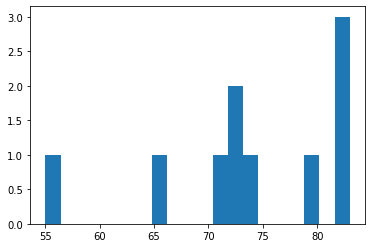

In [96]:
# histogram of max 0th percentile values across all channels

plt.hist(zeroth_perc.max().to_frame()[0],bins = 20)

Text(0.5, 0.98, 'Channel 0 -- percentiles')

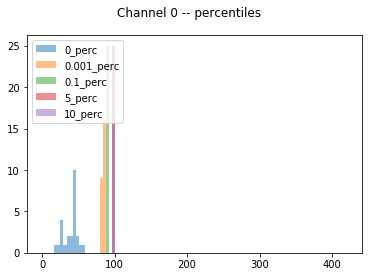

In [97]:
# replace with whatever channel you want to check
plt.hist(percentiles['ch0_0th_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '0_perc')
plt.hist(percentiles['ch0_0.001st_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '0.001_perc')
plt.hist(percentiles['ch0_0.1st_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '0.1_perc')
plt.hist(percentiles['ch0_5th_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '5_perc')
plt.hist(percentiles['ch0_10th_perc'], bins = 100, alpha=0.5, range=[0, 420], label = '10_perc')
plt.legend(loc='upper left')
plt.suptitle(f"Channel 0 -- percentiles")

In [ ]:
### for looking at all of the channels 
for i in range(38):
    fig, axes = plt.subplots()
    plt.hist(percentiles[f'ch{i}_0th_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '0_perc')
    plt.hist(percentiles[f'ch{i}_0.001st_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '0.001_perc')
    plt.hist(percentiles[f'ch{i}_0.1st_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '0.1_perc')
    plt.hist(percentiles[f'ch{i}_5th_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '5_perc')
    plt.hist(percentiles[f'ch{i}_10th_perc'], bins = 100, alpha=0.5, range=[0, 110], label = '10_perc')
    plt.legend(loc='upper left')
    plt.suptitle(f"Channel {i} -- percentiles")
    
#     fig, axes = plt.subplots()
#     sns.heatmap(dfY, vmin=-100, vmax=100)
#     pl.suptitle(f"Cycle {c+1} Y-shift")